In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import prep_for_model_runs as prep
import model_params_class as mp
import run_models as run
import sys
import generate_matrix as inputs
sys.path.append('../')

resident hours --- white: 92.1702477472447, black: 92.744517984031
saving group size matrix to GROUP_SIZE.csv
5.4792118701645955e-06
5.714285714285714
12.857142857142858
12.857142857142858
white of black white police 0.7352216748768473 black: 0.26477832512315275
white --> police 6.895951865
 white --> police_contact 0.014371166754051723 + 0.005175545815948276 = 0.01954671257
72


C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
C:\Users\meyer\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\generate_matrix.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\meyer\Anaconda3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.1.19  |       haa95532_0         160 KB
    certifi-2020.12.5          |   py37haa95532_0         144 KB
    conda-4.9.2                |   py37haa95532_0         3.1 MB
    matplotlib-3.1.1           |   py37hc8f65d3_0         6.6 MB
    ------------------------------------------------------------
                                           Total:         9.9 MB

The following packages will be UPDATED:

  ca-certificates                               2020.6.24-0 --> 2021.1.19-haa95532_0
  certifi                                  2020.6.20-py37_0 --> 2020.12.5-py37haa95532_0
  conda                                        4.8.3-py37_0 --> 4.9.2-py37haa95532_0
  matplotl

## Deterministic SIR model for multi-groups 
See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002176/


The model works like this: 
- Let's say we have N groups with size n_0 .... n_N
- Define four vectors (S = 'Susceptible, I = Infected, R = Recovered, D = Died) for each of the groups
    - for example: $\vec{I} = < I_0, I_1 \dots I_N >$ is the vector for the number of currently infected people in each subpopulation
- Assume a "contact matrix" $C = c_{ij} $ where $c_{ij}$ is the expected rate of contacts between groups i and j.
    - for example if $c_{i,j}$ = 0.1 that means that average number of contacts that an individual in group i has with group j is 0.1 --> i.e. there is a 1/10 chance they see anyone 
- Assume a "transmission matrix" $T = t_{ij}$ where $t_{ij}$  is the expected transmission between groups i and j if they make contact
    - The following code assumes that this is 1 (e.g. transmission rate is rolled into contact matrix) and is constant across groups. 
    - In a more sophisticated model, this assumption is not true. The transmission rate should not even be reciprocal. For example, if police are wearing masks when they interact with a community member, but there hands are equipment are dirty transmission rate could be higher in one direction. Transmission rate could also be higher for different types of interactions
- $\vec{\gamma}$ is the recovery rate .. e.g. $\gamma_i$ the likelihood that on a given day a sick person in group i recovers. We are using 1/14
- $\vec{\mu}$ is the death rate (divided by average disease duration) for each group

Combining contact and transmission, we can define a vector $\vec{\lambda}$ where $\lambda_i$ is the new infection rate (called the force of infection in the literature). 

- Force of infection = contact x transmission or $\lambda_i = \sum_j^N c_{ij} * t_{ij} $

Given $\vec{\lambda}$ the vector with contact rate * transmission rate, we can define our differential equations as follows:(Note that $t$ is current time and $t-1$ is previous time point. 

- Sub population totals : $\vec{N} = \vec{I_t} + \vec{R_t} + \vec{S_t} + \vec{D_t}$
- Susceptible number of people by sup-population: $\vec{S_t} = \vec{S_{t-1}} - \vec{I_{t-1}}$
- Infected by subpopulation $\vec{I_t} = \vec{I_{t-1}}+  \vec{\lambda} * \vec{S_{t-1}} * \frac{\vec{I_{t-1}}}{\vec{N}} - \vec{\gamma} \vec{I_{t-1}} - \vec{\mu} \vec{I_{t-1}}$ 
    - $\vec{I_t} =$ infected people before + newly infected people - infected people who recover
    - newly infected people = susceptible population * contact rate * transmission rate * proportion of population infected 
    - $\frac{\vec{I_{t-1}}}{\vec{N}}$ is the proportion of members of each group that are infected
- Recovered by Group: $\vec{R_t} = \vec{R_{t-1}} + \vec{\gamma} \vec{I_{t-1}}$

The implementation of this model does not try to count the number of individuals who have died, which simplifies it. 

In [3]:
def clean_df_names(df):
    df.columns = df.columns.str.strip()
    df.index = df.index.map(lambda s: s.strip())
    return df

In [5]:
"""Run multiple versions of the model, varying certain parameters to quantify uncertainty

params
------
base_dir: String
    the name of the directory where contact matrices and group size matrices are stored
    
starting_params: object of class ModelParams
    contains the initial parameters for the original model run
    
prison_peak_date: Int
    the day on which the prison infection rate peaks
    
days: Int
    the number of days to run the model for
    
returns
-------
monster_summary_stats: a DataFrame of all of the summary statistics for the model runs
infection_maps: a dictionary where the keys are stylized versions of a list of the starting parameters and the 
    values are infection_df's generated by these combinations of starting parameters
pd.concat(pop_sizes): a DataFrame that is a stacked version of all pop_size_df's output by the various model runs
"""
def run_models(policy_input_dirs, starting_params, prison_peak_date, days):
    monster_summary_stats = pd.DataFrame({})
    infection_maps = {}
    s_maps = {}
    pop_sizes = []
    pc = 10 #police contacts
    pgrp = 17 #police group size. Eventually should parametrize of have the dif. uncertainty
    prison_infection_rate = 0.35
    for policy_name, policy_input_path in policy_input_dirs.items():
        params = starting_params.add_uncertainty_params(prison_infection_rate, pc, pgrp)
        contact_data_post_sip = pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_POST_SIP)).set_index('Group_Name')
       
        contact_data_pre_SIP = clean_df_names(pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_PRE_SIP)).set_index('Group_Name'))

        group_size_data = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_MATRIX), index_col = 0)
        
        if policy_name == inputs.LEVER_1_FOLDER:
            jail_release_date = starting_params.sip_start_date + 7
            jail_release_shrink = 0.4
            #group_size_2 = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_PRISON_MATRIX))
            print("prison_lockdown_date")
            summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, prison_peak_date, jail_release_shrink, jail_release_date)
        elif policy_name == inputs.LEVER_2_FOLDER:
            # For the below, we would change 0 and (1-0.95) if we want to change our rates
            prison_sip_i_white = 516.47/(13621+516.47)*0
            prison_sip_i_black = 563.16/(8953+563.16)*0
            jail_sip_i_white = 13621/(13621+516.47)*0
            jail_sip_i_black = 8953/(8953+563.16)*0
            summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, prison_peak_date, prison_sip_i_white, 
                prison_sip_i_black, jail_sip_i_white, jail_sip_i_black)    
        else: 
            summary, infection_df, s_df, pop_size_df = run.run_models(
                policy_input_path, starting_params, days, group_size_data,contact_data_pre_SIP,
                        contact_data_post_sip, prison_peak_date)                                             

        infection_maps[policy_name] = infection_df
        s_maps[policy_name] = s_df
        pop_sizes.append(pop_size_df)
        summary['Policy_Lever'] = policy_name        
        summary['Initial_Infections'] = starting_params.initial_infection_multiplier
        summary['Lockdown_Date'] = starting_params.sip_start_date
        summary['Prison_Rate'] = starting_params.prison_infection_rate
        summary['Police_Contact_Rate'] = 10
        summary['Police_Group_Size'] = 17 # Todo add to contact matrix code that we produce several of these. 
        #Then modify code accordingly
        monster_summary_stats= monster_summary_stats.append(summary)
        
    return monster_summary_stats, infection_maps, s_maps, pd.concat(pop_sizes)
    

In [6]:
%load_ext autoreload
%autoreload 2

In [13]:
#writing the matrices, we could return them so we wouldn't need to read them again 
INPUT_BASE_DIR = '../input2'
import generate_matrix as inputs


original_dir, lever_1_dir, lever_2_dir = inputs.write_all_matrices(INPUT_BASE_DIR)

resident hours --- white: 92.1702477472447, black: 92.744517984031
saving group size matrix to GROUP_SIZE.csv
5.4792118701645955e-06
5.714285714285714
12.857142857142858
12.857142857142858
white of black white police 0.7352216748768473 black: 0.26477832512315275
white --> police 6.895951865
 white --> police_contact 0.014371166754051723 + 0.005175545815948276 = 0.01954671257
72


C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\generate_matrix.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_at_home = home[home['Race'] == 'White']
C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\generate_matrix.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [16]:
inputs.compare_to_spread_sheet()

resident hours --- white: 92.1702477472447, black: 92.744517984031
saving group size matrix to GROUP_SIZE.csv
5.4792118701645955e-06
5.714285714285714
12.857142857142858
12.857142857142858
white of black white police 0.7352216748768473 black: 0.26477832512315275
white --> police 6.895951865
 white --> police_contact 0.014371166754051723 + 0.005175545815948276 = 0.01954671257
72
Verifying Post SIP Matrix: spread_sheet --> code
checking row White
     White, White: 5.273907789 != 5.275936124996095
checking row White_Forced_Labour_At_Work
     White_Forced_Labour_At_Work, White_Forced_Labour_At_Work: 10.13625977 != 10.134973888210517
checking row White_Forced_Labour_At_Home
checking row Black
checking row Black_Forced_Labour_At_Work
     Black_Forced_Labour_At_Work, White_Forced_Labour_At_Work: 10.13625977 != 10.134973888210517
checking row Black_Forced_Labour_At_Home
     Black_Forced_Labour_At_Home, White_Police_At_Work: 0.02584202286 != 0.016612728982734873
     Black_Forced_Labour_At_

/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_at_home['hours_prop'] = white_at_home['Race_Home_Hours'] / white_at_home['Race_Home_Hours'].sum()
/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:249: SettingWithCopyWarning: 
A value is trying to be set on a c

In [14]:
# Initial Input Parameters
PRISON_PEAK_DATE = 35
TRANSMISSION_RATE = 0.015
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE =10

OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 120

In [15]:
starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE)

summary_stats, infection_maps, s_maps, group_sizes = run_models({inputs.ORIGINAL_FOLDER: original_dir,
                                                                  inputs.LEVER_1_FOLDER : lever_1_dir,
                                                                  inputs.LEVER_2_FOLDER: lever_2_dir},
                                                                  starting_params, PRISON_PEAK_DATE, DAYS)

prison_lockdown_date
policy_lever_1
policy_lever_1


C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\run_models.py:120: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  pop_size_df = pd.concat(pop_series, axis = 1).transpose()
C:\Users\meyer\Documents\NEW_REPO_CPE_Covid\CPE_Covid_Model\model\run_models.py:124: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return summary_stats_original, pd.concat(infection_rates), pd.concat(s_rates), pop_size_df
C:\Users\meyer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. 

In [16]:
summary_stats.to_csv(os.path.join(OUTPUT_DIR, 'full_summary_stats.csv'))

In [17]:
summary_stats[summary_stats['Policy_Lever'] == 'lever1'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Group_Name,,
Black,original,94323.0
Black_Forced_Labour,original,53260.0
White,original,808417.0
White_Forced_Labour,original,231368.0
Total_Residents,original,1187368.0
Total_w_Police,original,1193609.0


In [18]:
summary_stats.head()

,model_tag,cumulative_infected_40_days,cumulative_rate_40_days,active_rate_before_peak,cumulative_before_peak,cumulative_rate_before_peak,days_peak,peak_active_infected_rate,cumulative_peak,cumulative_rate_peak,...,cumulative_rate_after_peak,cumulative_infected_120_days,cumulative_rate_120_days,model_name,Policy_Lever,Initial_Infections,Lockdown_Date,Prison_Rate,Police_Contact_Rate,Police_Group_Size
Group_Name,,,,,,,,,,,,,,,,,,,,,
Black,I10_PI0.35_L14___pc10_pgrp17,89507.0,0.115980,0.307948,258723.0,0.335244,55,0.398956,397357.0,0.514882,...,0.447462,555441.0,1.0,original,no_policy,10,14,0.35,10,17
Black_Forced_Labour,I10_PI0.35_L14___pc10_pgrp17,52098.0,0.285456,0.496905,103961.0,0.569624,50,0.513598,114504.0,0.627392,...,0.677039,177097.0,1.0,original,no_policy,10,14,0.35,10,17
White,I10_PI0.35_L14___pc10_pgrp17,786224.0,0.206891,0.328009,1441500.0,0.379323,50,0.334066,1581971.0,0.416287,...,0.451046,3537427.0,1.0,original,no_policy,10,14,0.35,10,17
White_Forced_Labour,I10_PI0.35_L14___pc10_pgrp17,227253.0,0.334442,0.500845,399818.0,0.588400,49,0.502989,416643.0,0.613161,...,0.678180,671457.0,1.0,original,no_policy,10,14,0.35,10,17
Total_Residents,I10_PI0.35_L14___pc10_pgrp17,1155082.0,0.212568,0.352445,2204002.0,0.405599,50,0.363152,2432693.0,0.447685,...,0.486530,4941423.0,1.0,original,no_policy,10,14,0.35,10,17


In [19]:
summary_stats[summary_stats['Policy_Lever'] == 'lever2'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Group_Name,,
Black,original,89507.0
Black_Forced_Labour,original,52098.0
White,original,786224.0
White_Forced_Labour,original,227253.0
Total_Residents,original,1155082.0
Total_w_Police,original,1161708.0


In [20]:
summary_stats[summary_stats['Policy_Lever'] == 'no_policy'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Group_Name,,
Black,original,89507.0
Black_Forced_Labour,original,52098.0
White,original,786224.0
White_Forced_Labour,original,227253.0
Total_Residents,original,1155082.0
Total_w_Police,original,1161708.0
Black,no_police,88535.0
Black_Forced_Labour,no_police,51969.0
White,no_police,783943.0


In [21]:
summary_stats[summary_stats['Policy_Lever'] == 'no_policy'].loc[['White']][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Group_Name,,
White,original,786224.0
White,no_police,783943.0
White,no_prison,786126.0
White,no_prison_or_police,783847.0
White,no_forced_labour,16518.0
White,no_police_prison_fl,10201.0


In [22]:
infection_no_policy = infection_maps['no_policy']

In [23]:
infection_no_policy

,Black,Black_Forced_Labour,Black_Police,Black_Prison,Day,Policy_Lever,Total_Residents,Total_w_Police,White,White_Forced_Labour,White_Police,White_Prison,model_name,name
0,42.285517,10.000000,0.199706,0.000000,0,no_policy,297.737223,298.492406,208.220461,37.231245,0.555477,0.000000,original,I10_PI0.35_L14___pc10_pgrp17
1,48.040502,11.597256,0.269978,1.000000,1,no_policy,308.901985,309.827013,210.708438,38.555788,0.655050,1.000000,original,I10_PI0.35_L14___pc10_pgrp17
2,57.633496,15.293054,0.362581,1.276931,2,no_policy,384.795761,386.072399,259.309616,52.559594,0.914058,1.281101,original,I10_PI0.35_L14___pc10_pgrp17
3,70.227956,20.123529,0.484696,1.630553,3,no_policy,482.519889,484.254792,321.579164,70.589240,1.250207,1.641220,original,I10_PI0.35_L14___pc10_pgrp17
4,86.718559,26.421078,0.645419,2.082105,4,no_policy,608.252132,610.583803,401.335230,93.777265,1.686251,2.102570,original,I10_PI0.35_L14___pc10_pgrp17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1363.079858,0.000000,6.576244,5198.322864,116,no_policy,50035.269484,50152.869901,48672.189627,0.000000,111.024173,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
117,1304.002268,0.000000,6.207041,5198.322864,117,no_policy,50876.059675,50988.835780,49572.057407,0.000000,106.569064,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
118,1248.581796,0.000000,5.859720,5198.322864,118,no_policy,51731.118149,51839.276825,50482.536353,0.000000,102.298957,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
119,1196.573801,0.000000,5.532930,5198.322864,119,no_policy,52600.091787,52703.830319,51403.517986,0.000000,98.205603,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17


In [24]:
p = group_sizes.loc['no_policy_original']

Group_Name
Black                                 771744.512940
Black_Forced_Labour                   182508.000000
Black_Police                            3644.800000
Black_Prison                           14852.351039
White                                3800189.998699
White_Forced_Labour                   679500.000000
White_Police                           10137.898400
White_Prison                           16647.648961
Total_Residents                      5433942.511639
Total_w_Police                       5447725.210039
name                   I10_PI0.35_L14___pc10_pgrp17
Name: no_policy_original, dtype: object

In [25]:
infection_no_policy

,Black,Black_Forced_Labour,Black_Police,Black_Prison,Day,Policy_Lever,Total_Residents,Total_w_Police,White,White_Forced_Labour,White_Police,White_Prison,model_name,name
0,42.285517,10.000000,0.199706,0.000000,0,no_policy,297.737223,298.492406,208.220461,37.231245,0.555477,0.000000,original,I10_PI0.35_L14___pc10_pgrp17
1,48.040502,11.597256,0.269978,1.000000,1,no_policy,308.901985,309.827013,210.708438,38.555788,0.655050,1.000000,original,I10_PI0.35_L14___pc10_pgrp17
2,57.633496,15.293054,0.362581,1.276931,2,no_policy,384.795761,386.072399,259.309616,52.559594,0.914058,1.281101,original,I10_PI0.35_L14___pc10_pgrp17
3,70.227956,20.123529,0.484696,1.630553,3,no_policy,482.519889,484.254792,321.579164,70.589240,1.250207,1.641220,original,I10_PI0.35_L14___pc10_pgrp17
4,86.718559,26.421078,0.645419,2.082105,4,no_policy,608.252132,610.583803,401.335230,93.777265,1.686251,2.102570,original,I10_PI0.35_L14___pc10_pgrp17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1363.079858,0.000000,6.576244,5198.322864,116,no_policy,50035.269484,50152.869901,48672.189627,0.000000,111.024173,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
117,1304.002268,0.000000,6.207041,5198.322864,117,no_policy,50876.059675,50988.835780,49572.057407,0.000000,106.569064,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
118,1248.581796,0.000000,5.859720,5198.322864,118,no_policy,51731.118149,51839.276825,50482.536353,0.000000,102.298957,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17
119,1196.573801,0.000000,5.532930,5198.322864,119,no_policy,52600.091787,52703.830319,51403.517986,0.000000,98.205603,5826.677136,no_police_prison_fl,I10_PI0.35_L14___pc10_pgrp17


In [26]:
# Look at the infection rates for just one racial group
infection_no_policy[infection_no_policy['model_name'].isin(['original', 'no_police']) & (infection_no_policy['Day'] == 30)]

,Black,Black_Forced_Labour,Black_Police,Black_Prison,Day,Policy_Lever,Total_Residents,Total_w_Police,White,White_Forced_Labour,White_Police,White_Prison,model_name,name
30,10441.495022,6404.523709,242.574836,1199.107505,30,no_policy,136950.870663,137943.424083,91709.407173,28395.444759,749.978585,1318.014594,original,I10_PI0.35_L14___pc10_pgrp17
30,10303.820156,6382.816984,242.085041,1199.107505,30,no_policy,136389.814993,137381.020925,91352.542995,28350.634859,749.120890,1318.014594,no_police,I10_PI0.35_L14___pc10_pgrp17


In [27]:
np.round(s_maps['no_policy'][infection_no_policy['model_name'].isin(['original'])]['Black'])[0:10]

0    771702.0
1    771696.0
2    771687.0
3    771674.0
4    771658.0
5    771636.0
6    771608.0
7    771572.0
8    771524.0
9    771463.0
Name: Black, dtype: float64

In [28]:
infection_no_policy[infection_no_policy['model_name'].isin(['original'])]['Black']

0        42.285517
1        48.040502
2        57.633496
3        70.227956
4        86.718559
          ...     
116    5933.615903
117    5744.733063
118    5563.057961
119    5388.223040
120    5219.889240
Name: Black, Length: 121, dtype: float64

original
760349.8178008195
original
175744.43430523557
original
5290308.583510732
no_police
760493.0812200402
no_police
175767.28962180417
no_police
5290893.1917205155
original
3704356.027318305
original
649858.304086372
no_police
3704727.3883907693
no_police
649905.4324879026


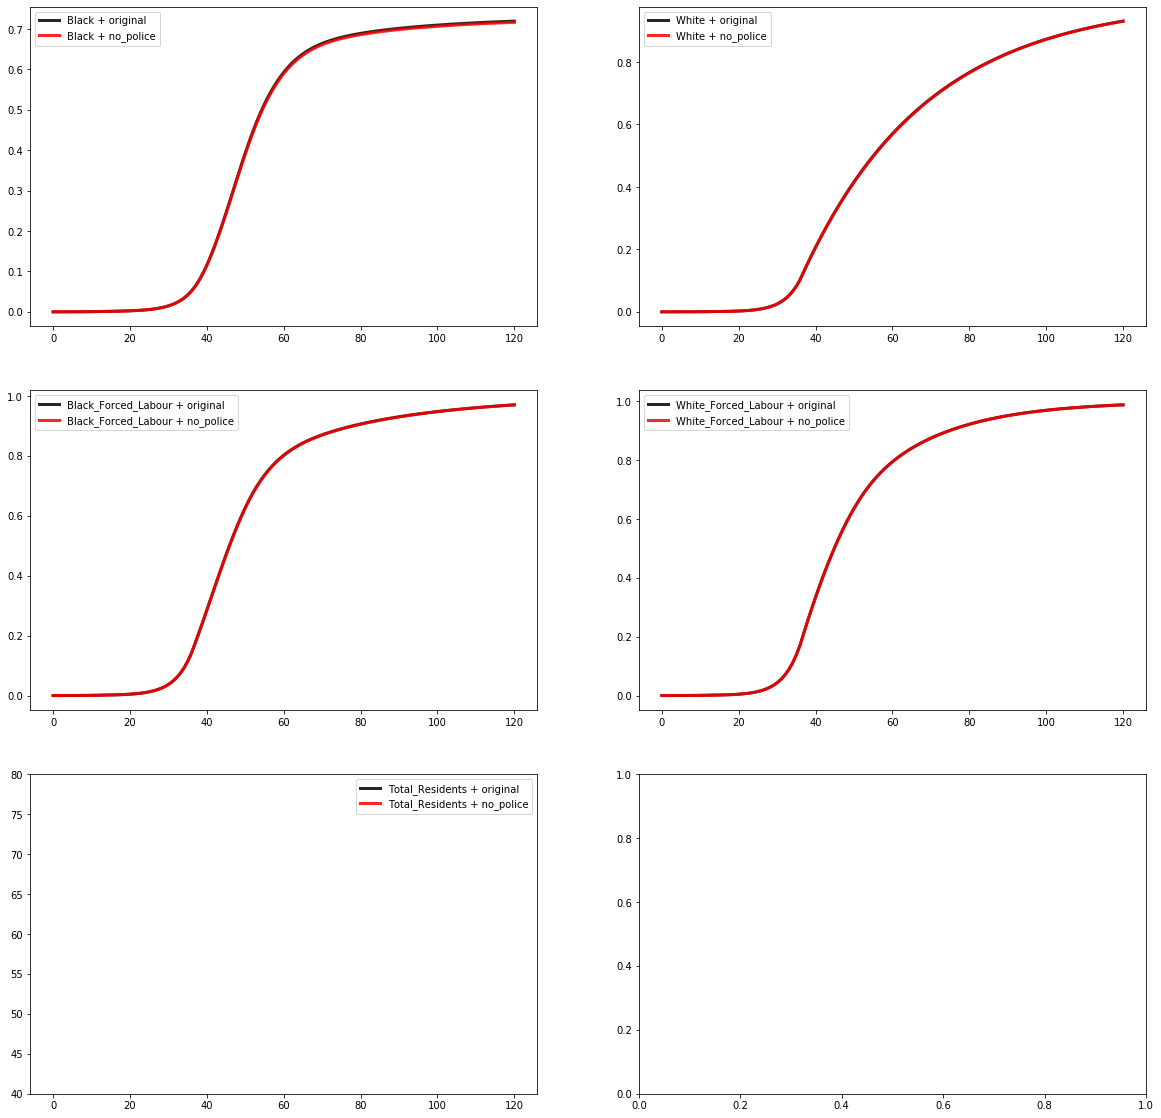

In [29]:
model_colors = {
    'original' : 'k',
   # 'eq_forced_labour': 'p',
  #  'no_prison': 'b',
    'no_police': 'g'
   # 'no_prison_or_police': 'r'
#     'no_forced_labour' : 'orange'
}

def plot_infection_number_seperate_race(ax,i,infections_df, group_size, groups, color_column, color_key):
    for k, v in color_key.items():
        df = infections_df[infections_df[color_column] == k]
        for j in range(0, len(groups)):
            group = groups[j]
            print(k)
            print(df[group].iloc[30])
            label_name = f'{group} + {k}'
            ax[j,i].plot(df['Day'].values, 1 - df[group]/group_size[group], v, alpha=0.85, lw=3, label = label_name)
            ax[j,i].legend()
            #ax[j,i].set_xlim(30, 50)
            
        
    
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))

plot_infection_number_seperate_race(ax, 0, s_maps['no_policy'], p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'model_name', {
    'original' : 'k',
    'no_police': 'r'} )
plot_infection_number_seperate_race(ax, 1, s_maps['no_policy'], p, ['White', 'White_Forced_Labour'], 'model_name', {
    'original' : 'k',
    'no_police': 'r'} )
ax[2,0].set_ylim(0,0.3)
ax[2,0].set_ylim(40, 80)
plt.show()


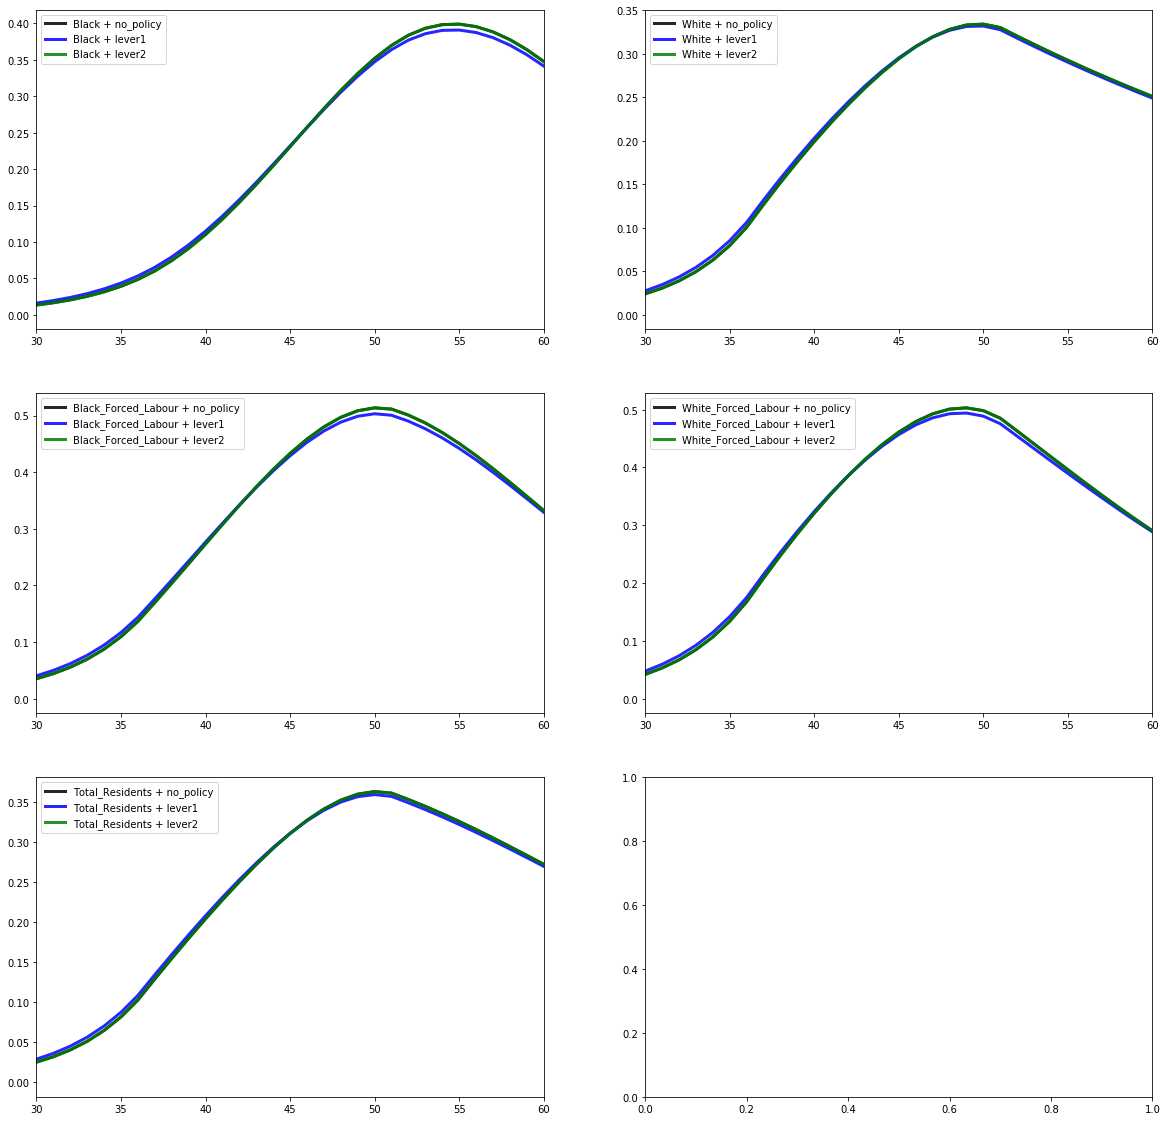

In [31]:
def plot_infection_number_seperate_race(ax,i,infections_df, group_size, groups, color_column, color_key):
    for k, v in color_key.items():
        df = infections_df[infections_df[color_column] == k]
        for j in range(0, len(groups)):
            group = groups[j]
            label_name = f'{group} + {k}'
            ax[j,i].plot(df['Day'].values, df[group]/group_size[group], v, alpha=0.85, lw=3, label = label_name)
            ax[j,i].legend()
            ax[j,i].set_xlim(30, 60)
            
        
    
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))

plot_infection_number_seperate_race(ax, 0, infection_no_policy[infection_no_policy['model_name'] == 'original'],
                                    p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {
    'no_policy' : 'k'} )

plot_infection_number_seperate_race(ax, 0, infection_maps['lever1'],
                                    p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {'lever1' : 'b'} )

plot_infection_number_seperate_race(ax, 0, infection_maps['lever2'], p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {'lever2' : 'g'})


plot_infection_number_seperate_race(ax, 1, infection_no_policy[infection_no_policy['model_name'] == 'original'],
                                    p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {
    'no_policy' : 'k'} )
plot_infection_number_seperate_race(ax, 1, infection_maps['lever1'],
                                    p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {'lever1' : 'b'} )

plot_infection_number_seperate_race(ax, 1, infection_maps['lever2'], p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {'lever2' : 'g'})
#ax[2,0].set_ylim(0.1,0.25)
#ax[2,0].set_xlim(40,60)
plt.show()

In [313]:
# Make Some Plots to Visualize The Infection In the Synthetic City

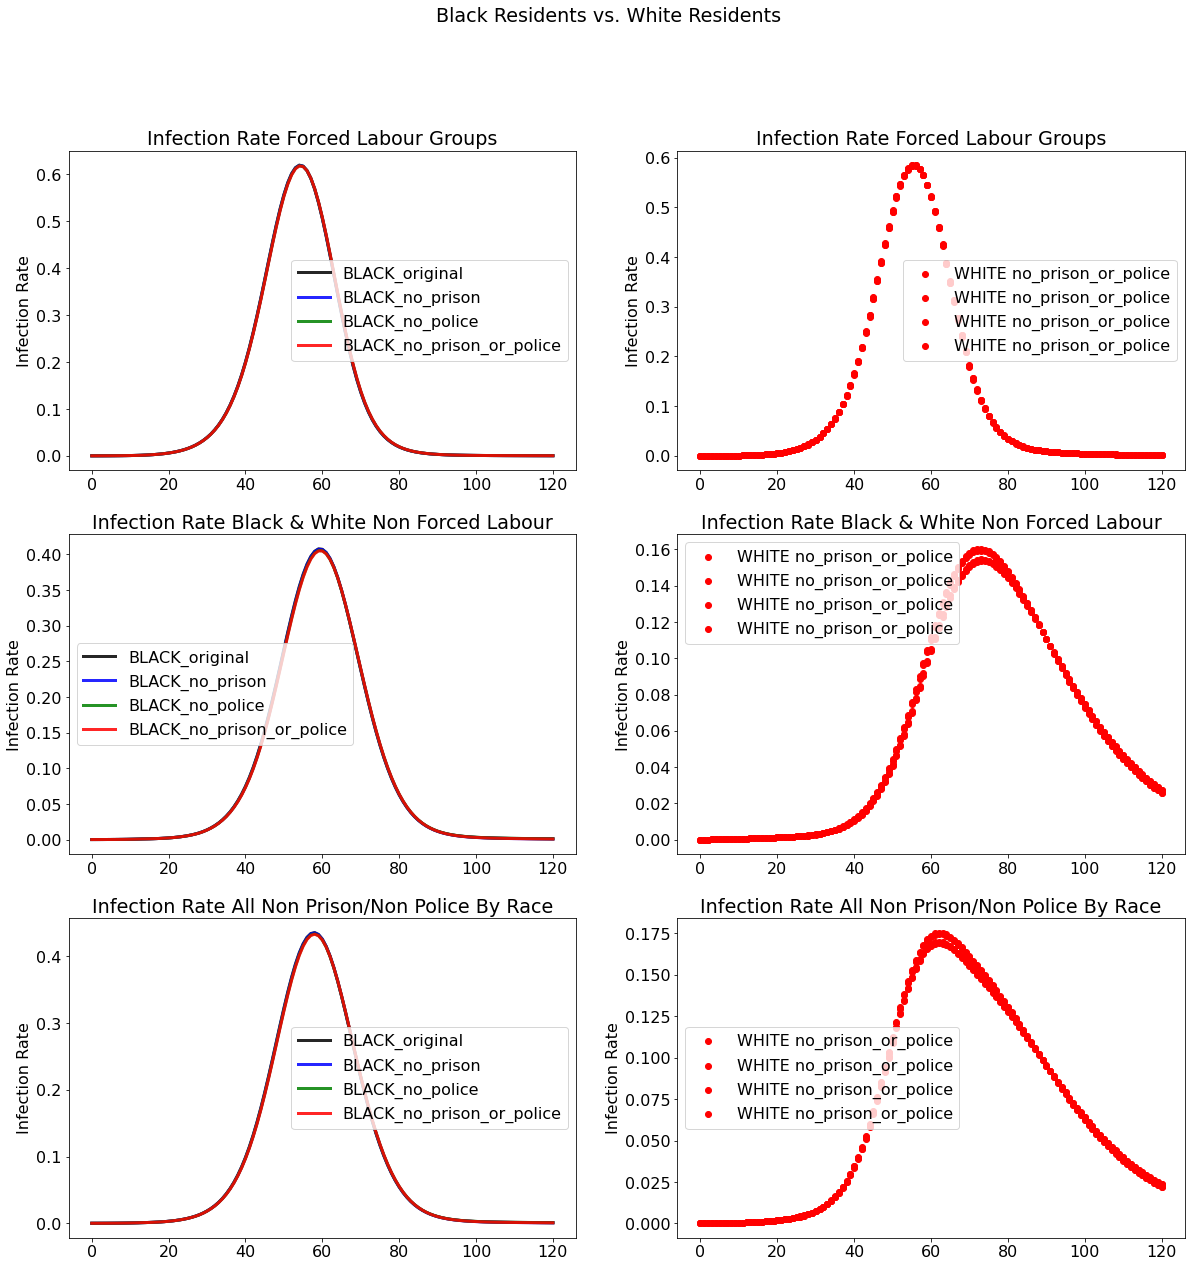

In [207]:
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Black Residents vs. White Residents")

model_colors = {
    'original' : 'k',
   # 'eq_forced_labour': 'p',
    'no_prison': 'b',
    'no_police': 'g',
    'no_prison_or_police': 'r'
#     'no_forced_labour' : 'orange'
}

for model_name in model_colors.keys():
    df = infection_no_policy[infection_no_policy['model_name'] == model_name].set_index('Day')
    pop_size = group_sizes.loc['no_policy_original']
    #print(k + "   " + str(pop_size['Black_Forced_Labour']))
    x = df['Black_Forced_Labour']/pop_size['Black_Forced_Labour']
    y = df['Black']/pop_size['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])/ (pop_size['Black'] + pop_size['Black_Forced_Labour'])

    ax[0, 0].plot(df.index, x , model_colors[model_name], alpha=0.85, lw=3, label = 'BLACK_' + model_name)
    ax[1,0].plot(df.index, y ,model_colors[model_name], alpha=0.85, lw=3, label='BLACK_' + model_name)
    ax[2,0].plot(df.index, z, model_colors[model_name], alpha =0.85, lw=3, label =  "BLACK_" + model_name)

    #if k in ['original', 'no_forced_labour']:
    z2 = (df['White'] + df['White_Forced_Labour'])/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,1].scatter(
        df.index, df['White_Forced_Labour']/pop_size['White_Forced_Labour'],
                color = model_colors[k], lw = 1, label = 'WHITE '+k)
    ax[1,1].scatter(df.index, df['White']/pop_size['White'], color = model_colors[k], lw = 1, label = 'WHITE '+ k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], lw = 1, label = 'WHITE '+k)
    
for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('Infection Rate')
        ax[r,c].legend(loc = 'best')
       # ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('Infection Rate Forced Labour Groups')
        ax[1,c].set_title('Infection Rate Black & White Non Forced Labour')
        ax[2,c].set_title('Infection Rate All Non Prison/Non Police By Race')
      #  ax[2,c].set_ylim(0, 0.2)
        

plt.show()

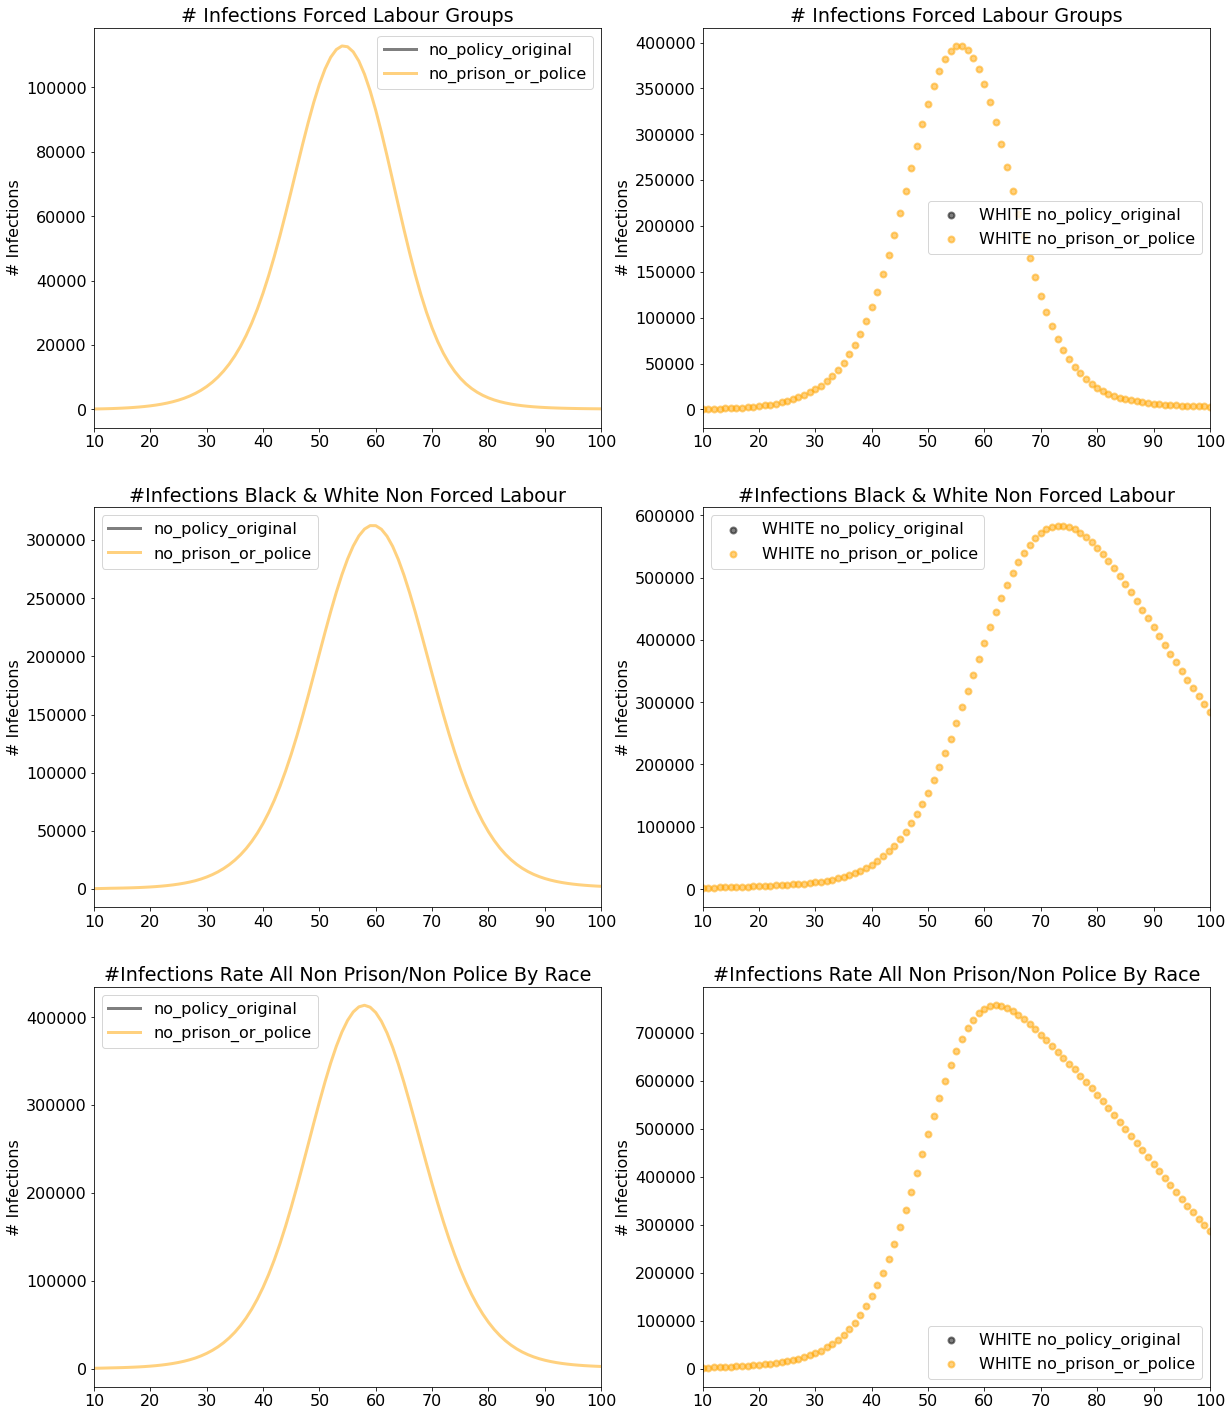

In [208]:
fig, ax = plt.subplots(3,2, figsize = (20, 25))
#fig.suptitle("Black Residents vs. White Residents")
plt.rc('font', size=16) 

model_colors = {
    'no_policy_original' : 'k',
    'no_prison_or_police' : 'orange'
}
for k in model_colors.keys():
    df = infection_no_policy[infection_no_policy['model_name'] == k]
    pop_size = group_sizes.loc[k]
    
    x = df['Black_Forced_Labour']
    y= df['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])

    x2 = df['White_Forced_Labour']
    y2 = df['White'] 
    z2 = (df['White'] + df['White_Forced_Labour'])

    #/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,0].plot(df.index, x , model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[1,0].plot(df.index, y ,model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[2,0].plot(df.index, z, model_colors[k], alpha = 0.5, lw = 3, label = k)

    #if k in ['original', 'eq_police_prison_fl']:
    ax[0,1].scatter(df.index, x2 , color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[1,1].scatter(df.index, y2 ,color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], alpha = 0.5, lw = 2, label ='WHITE ' + k)

for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('# Infections')
        ax[r,c].legend(loc = 'best')
        ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('# Infections Forced Labour Groups')
        ax[1,c].set_title('#Infections Black & White Non Forced Labour')
        ax[2,c].set_title('#Infections Rate All Non Prison/Non Police By Race')    

plt.show()